- DM project- Group 82
- Student: Diogo Pimenta nº 20230498 
- Student: Cláudia Beiral nº 20230387 
- Student: João Maia nº 20230746

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#import kmeans
from sklearn.cluster import KMeans
#improt silhouette_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from os.path import join
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

from minisom import MiniSom
from matplotlib import __version__ as mplver

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


In [2]:
df = pd.read_csv('XYZ_sports_dataset_preprocessed.csv', sep=';', index_col='ID')
df.head()

,Age,Income,DaysWithoutFrequency,LifetimeValue,NumberOfFrequencies,AttendedClasses,AllowedWeeklyVisitsBySLA,AllowedNumberOfVisitsBySLA,RealNumberOfVisits,NumberOfRenewals,...,SpecialActivities,OtherActivities,HasReferences,Dropout,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,RFM_Score_Labels
ID,,,,,,,,,,,,,,,,,,,,,
10001,29,2630.0,60,479.2,23.0,1,2.0,17.42,1,2,...,1.0,0.0,0.0,1,1,2,5,125,8,Medium Value
10002,23,1980.0,7,37.6,6.0,0,7.0,30.03,6,0,...,0.0,0.0,0.0,1,3,5,5,355,13,High Value
10003,9,0.0,22,155.4,20.0,2,2.0,17.72,3,0,...,0.0,0.0,0.0,1,4,4,4,444,12,High Value
10004,35,4320.0,210,373.2,41.0,0,7.0,60.97,0,3,...,0.0,0.0,0.0,1,3,2,2,322,7,Low Value
10005,24,2220.0,3,140.0,28.0,0,7.0,59.01,26,0,...,0.0,0.0,0.0,1,2,4,2,242,8,Medium Value



# Clustering Perspective 1: Purchase Behaviour
- Identifies high-value customers who are recent, frequent, and spend a significant amount. These customers are often crucial for business profitability.
- Reveals patterns in customer behavior that may not be apparent when looking at each metric individually. For instance, customers who make infrequent but high-value purchases.


In [3]:
df1 = df[["Recency","Frequency","Monetary"]]

- Scaling the Data

In [4]:
scaler = MinMaxScaler()
scaler.fit(df1)
df1_scaled = scaler.transform(df1)
df1_scaled = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
df1_scaled.head()

,Recency,Frequency,Monetary
ID,,,
10001,0.805755,0.084818,0.182834
10002,0.456835,0.305326,0.196677
10003,0.145427,0.172671,0.137974
10004,0.370504,0.081328,0.076206
10005,0.611511,0.161106,0.082582


## Applying k-Means 




### Dendogram visualization to inspect natural groups or where clusters are merging

In [5]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df1_scaled)

array([11965, 10160,  9637, ...,     4,     1,     0], dtype=int64)

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='c:\\Users\\diogo\\anaconda3\\envs\\environment_dm\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\diogo\\anaconda3\\envs\\environment_dm\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\diogo\\anaconda3\\envs\\environment_dm\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=

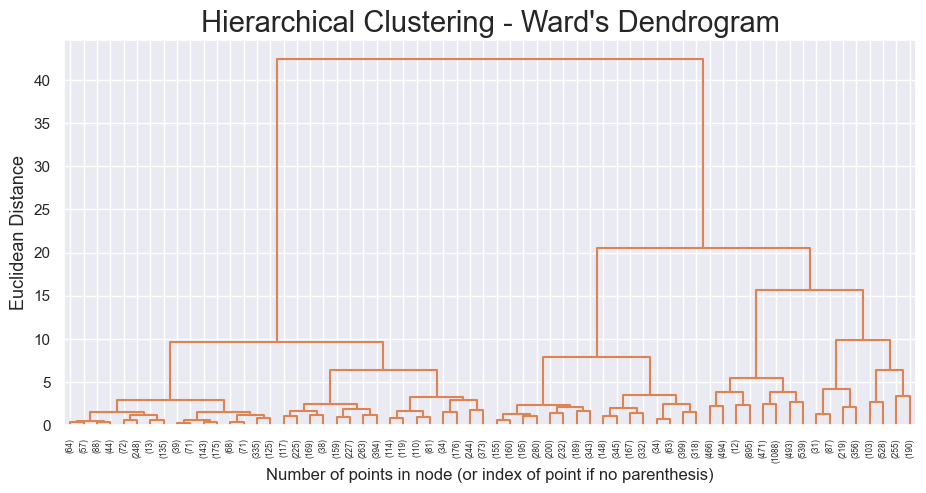

In [6]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### Defining the optimal K

In [7]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df1_scaled)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

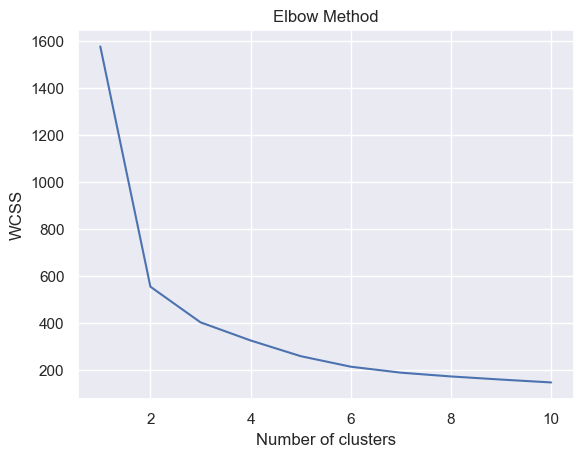

In [8]:
#perform elbow method
plt.plot(range_clusters, inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [9]:
#plot silhouette score for each cluster solution
range_clusters = range(2, 11)
silhouette = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df1_scaled)
    silhouette.append(silhouette_score(df1_scaled, kmclust.labels_))  # save the inertia of the given cluster solution
    

For n_clusters = 2, the average silhouette_score is : 0.5430578810320787
For n_clusters = 3, the average silhouette_score is : 0.41879943922091295
For n_clusters = 4, the average silhouette_score is : 0.4256694881518569
For n_clusters = 5, the average silhouette_score is : 0.3796737011151494
For n_clusters = 6, the average silhouette_score is : 0.3869583255389907
For n_clusters = 7, the average silhouette_score is : 0.36166797127538564
For n_clusters = 8, the average silhouette_score is : 0.32387940517155855
For n_clusters = 9, the average silhouette_score is : 0.3359849944599666
For n_clusters = 10, the average silhouette_score is : 0.3266743545937038


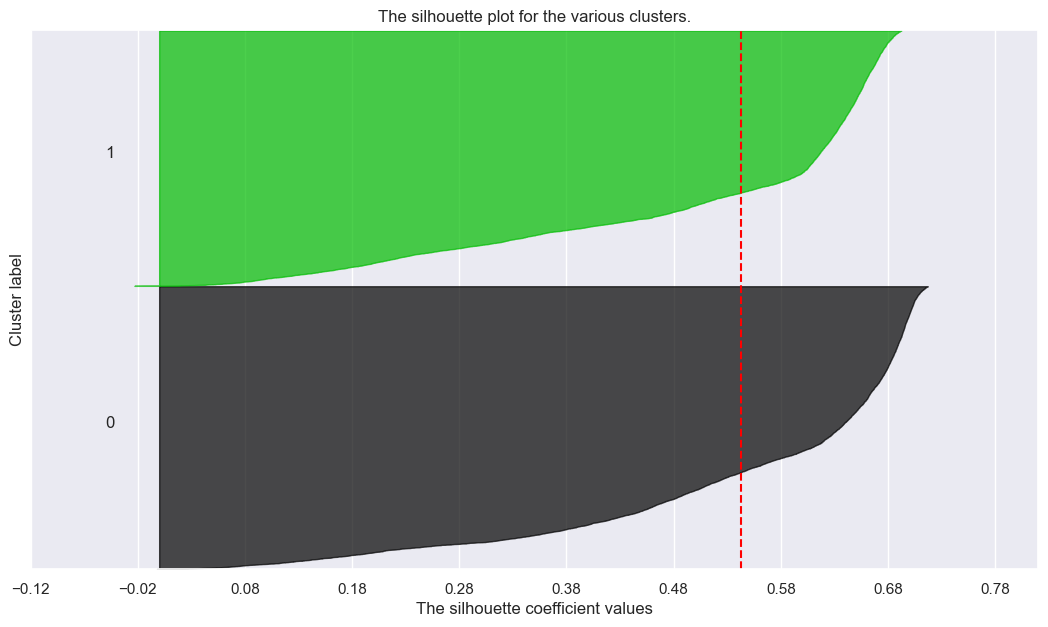

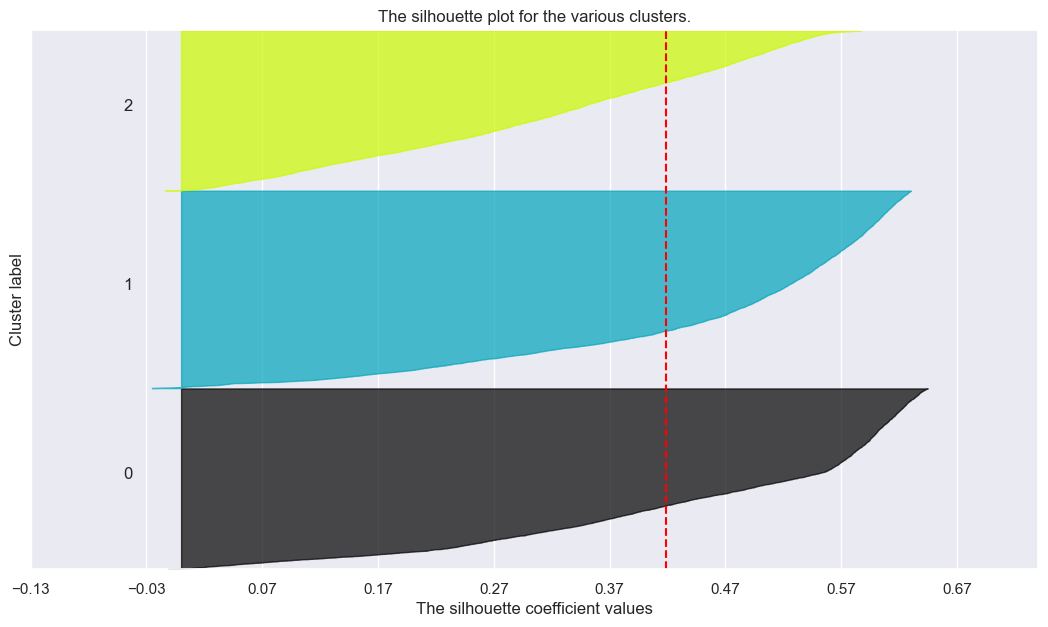

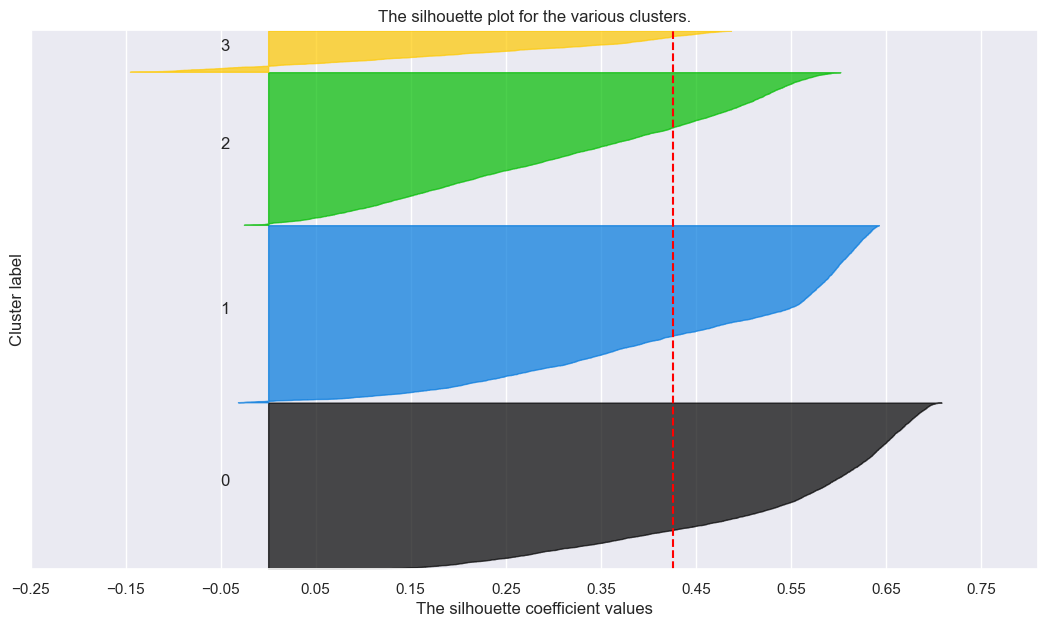

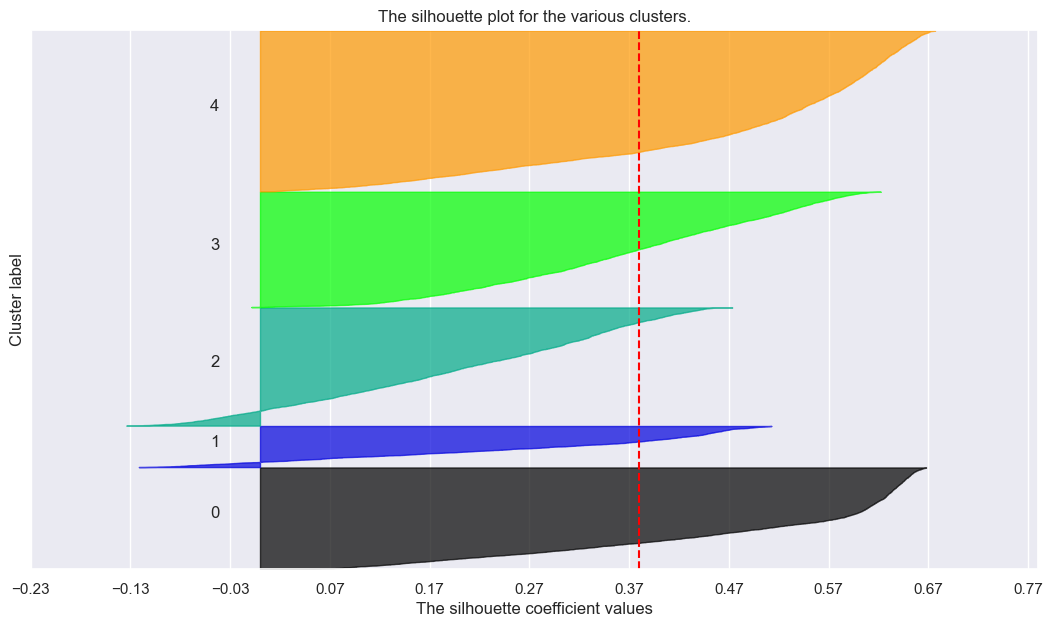

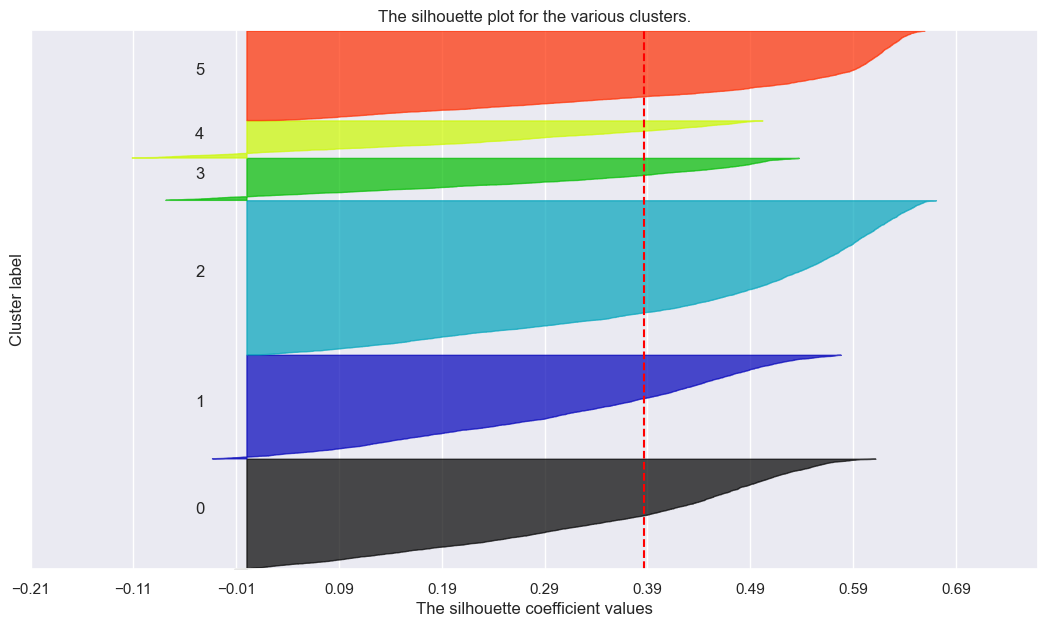

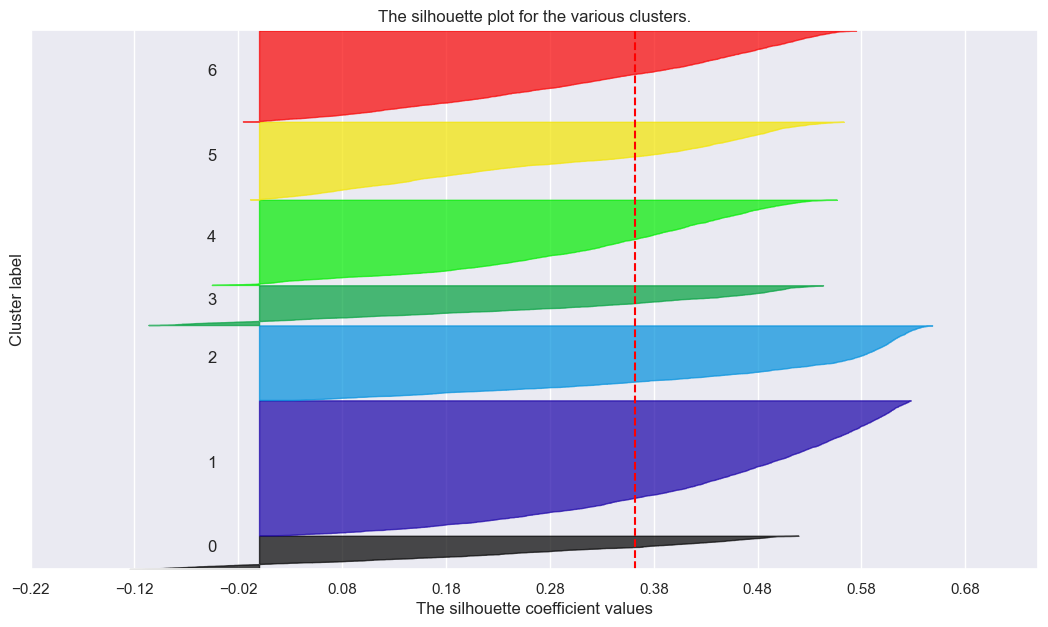

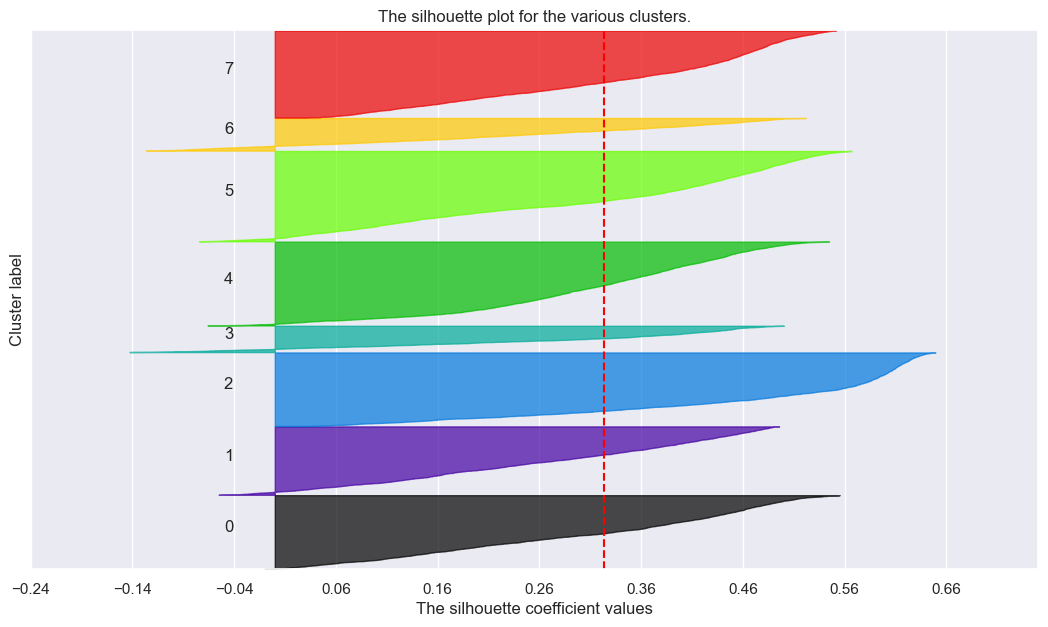

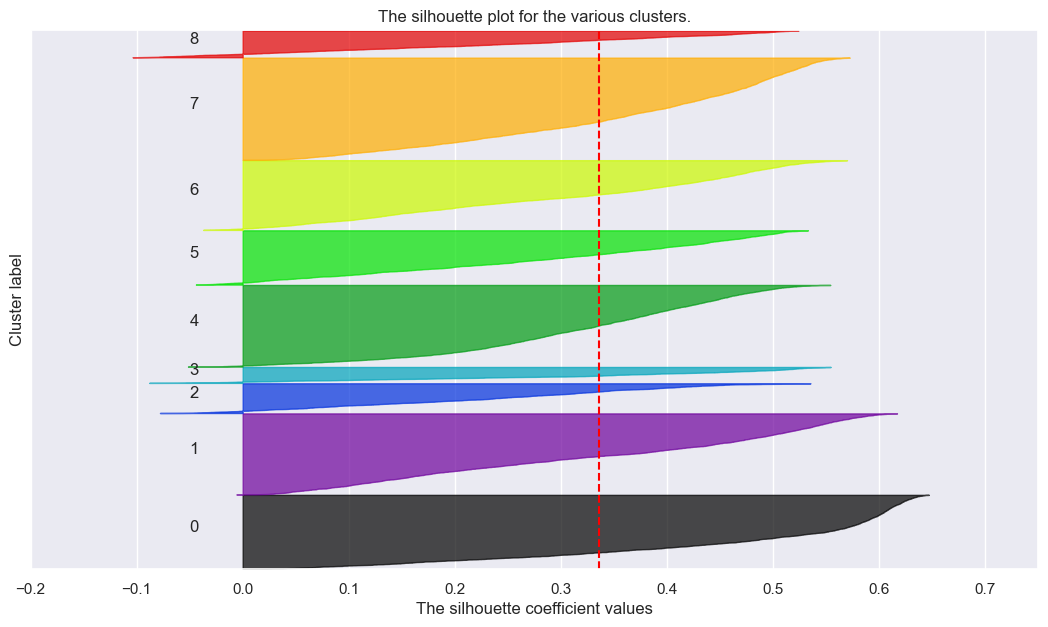

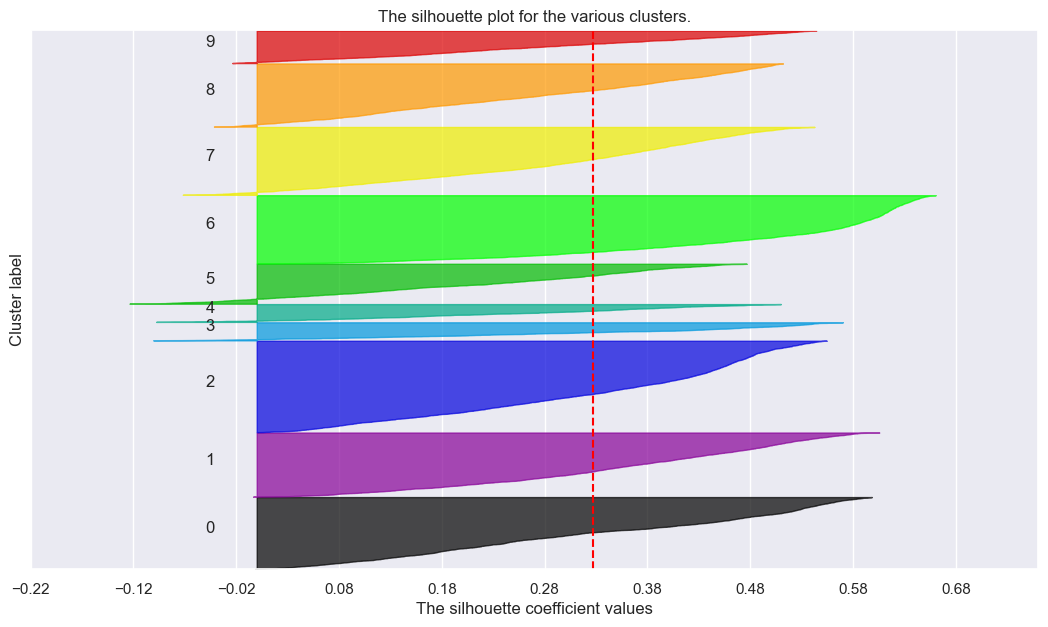

In [10]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df1_scaled)
    cluster_labels = kmclust.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df1_scaled, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df1_scaled, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df1_scaled) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1)) 

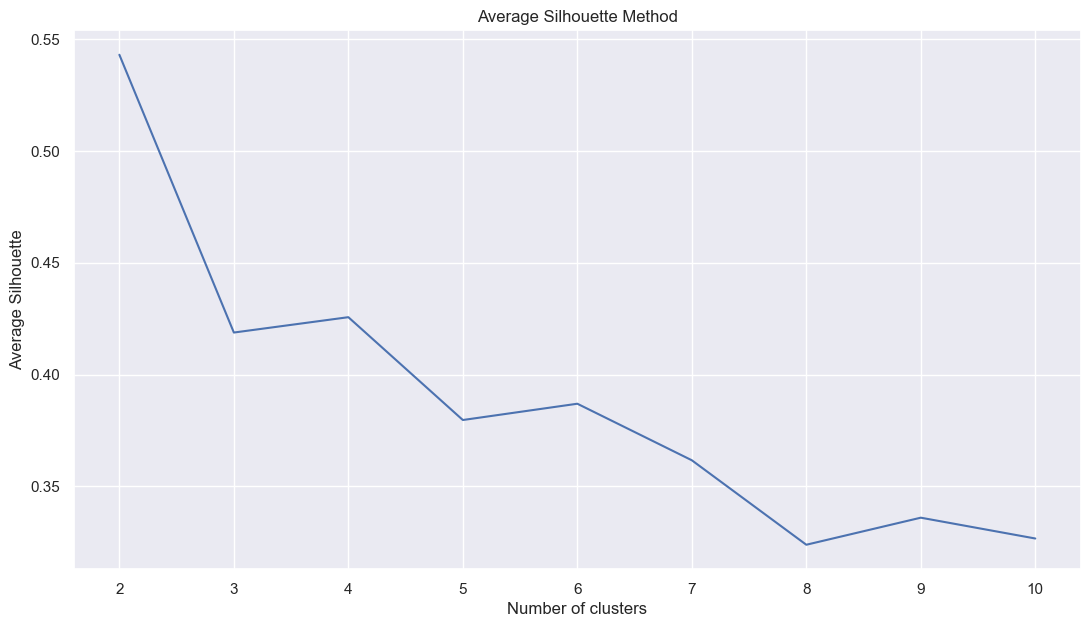

In [11]:
# The average silhouette plot
plt.figure(figsize=(13, 7))
plt.plot(range_clusters, avg_silhouette)
plt.title('Average Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette')
plt.show()


c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The 

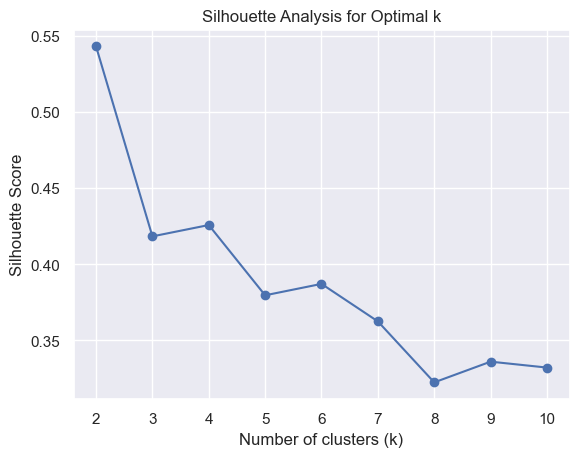

In [12]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df1_scaled)  # X is your data
    silhouette_avg = silhouette_score(df1_scaled, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


### Final Decision: K=3

In [13]:
#perform kmeans clustering with 3 clusters
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 1)
kmeans.fit(df1_scaled)
cluster_labels = kmeans.labels_


c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
df1_scaled["Cluster1"] = cluster_labels
df["Cluster1"] = cluster_labels
df1["Cluster1"] = cluster_labels

C:\Users\diogo\AppData\Local\Temp\ipykernel_4476\1945561946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Cluster1"] = cluster_labels


In [15]:
#silhouette score
silhouette_score(df1_scaled,cluster_labels)

0.8179969932540588

In [16]:
df["Cluster1"].value_counts()

Cluster1
1    5280
0    4827
2    4271
Name: count, dtype: int64

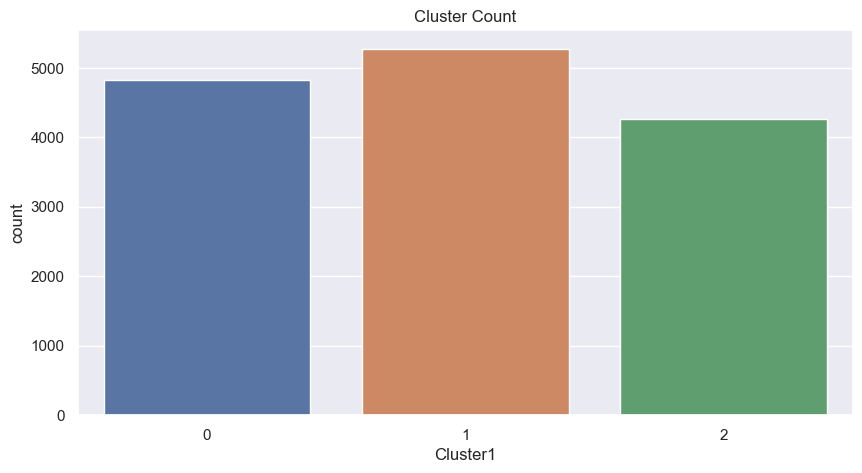

In [17]:
#plot the clusters in terms of count
plt.figure(figsize=(10,5))
sns.countplot(x=df["Cluster1"])
plt.title("Cluster Count")
plt.show()


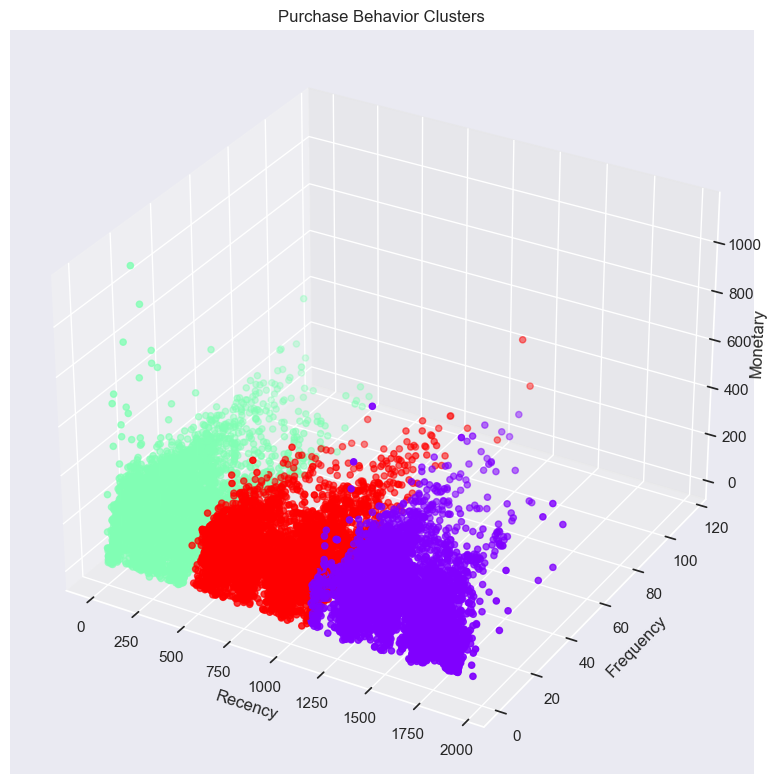

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df1["Recency"], df1["Frequency"], df1["Monetary"], c=df1["Cluster1"], cmap='rainbow')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Purchase Behavior Clusters')

ax.zaxis.labelpad=-0.8 
# Adjust layout to make sure z-axis label is visible
plt.tight_layout()
#add legend of colors

plt.show()


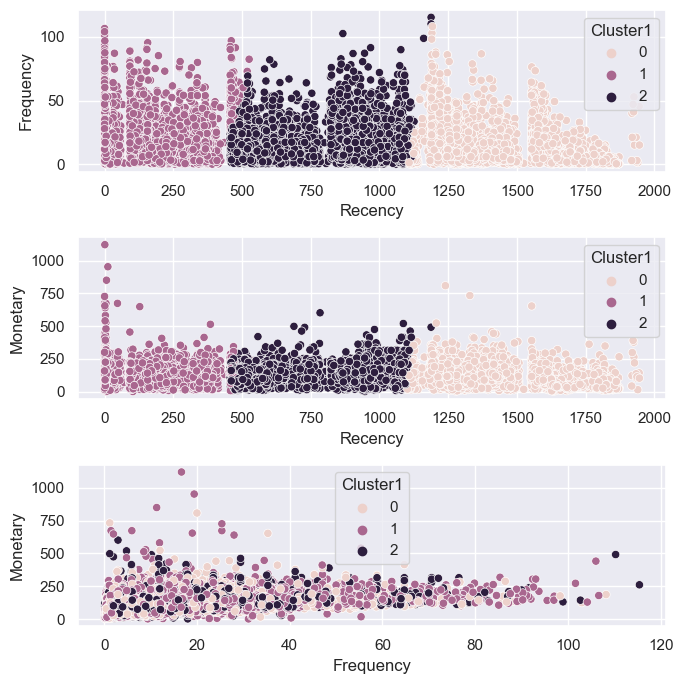

In [19]:
#scatter plot of r_score vs f_score, another for r_score vs m_score and another for f_score vs m_score
fig, axs = plt.subplots(3, 1, figsize=(7, 7))
sns.scatterplot(x="Recency", y="Frequency", hue="Cluster1", data=df, ax=axs[0])
sns.scatterplot(x="Recency", y="Monetary", hue="Cluster1", data=df, ax=axs[1])
sns.scatterplot(x="Frequency", y="Monetary", hue="Cluster1", data=df, ax=axs[2])
plt.tight_layout()
plt.show()


locator: <matplotlib.ticker.AutoLocator object at 0x00000212AA243AD0>


<Axes: ylabel='Cluster1'>

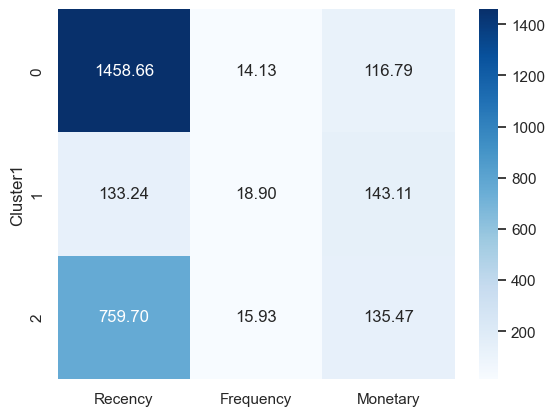

In [20]:
#plot heatmap of the clusters and the RFM variables
heatmap_data = df.groupby('Cluster1')[['Recency', 'Frequency', 'Monetary']].mean()
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f', )

In [21]:
df.groupby("Cluster1").agg({"Recency":"mean","Frequency":"mean","Monetary":'mean', "RFM_Score":["mean","count"]})

Recency  Frequency    Monetary  RFM_Score      
                 mean       mean        mean       mean count
Cluster1                                                     
0         1458.657344  14.133254  116.790455   6.793868  4827
1          133.244886  18.904112  143.106104  11.039015  5280
2          759.701241  15.933780  135.467891   8.939827  4271

In [22]:
df[df["Cluster1"]==0].describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,4827.0,26.0,12.0,0.0,20.0,23.0,29.0,85.0
Income,4827.0,2194.0,1352.0,0.0,1550.0,2010.0,2590.0,10890.0
DaysWithoutFrequency,4827.0,135.0,200.0,0.0,41.0,65.0,157.0,1745.0
LifetimeValue,4827.0,177.0,160.0,21.0,72.0,124.0,232.0,3498.0
NumberOfFrequencies,4827.0,22.0,26.0,1.0,6.0,13.0,28.0,276.0
AttendedClasses,4827.0,4.0,12.0,0.0,0.0,0.0,0.0,150.0
AllowedWeeklyVisitsBySLA,4827.0,6.0,2.0,1.0,7.0,7.0,7.0,7.0
AllowedNumberOfVisitsBySLA,4827.0,44.0,24.0,1.0,29.0,51.0,61.0,240.0
RealNumberOfVisits,4827.0,4.0,5.0,0.0,1.0,3.0,6.0,66.0
NumberOfRenewals,4827.0,1.0,1.0,0.0,0.0,1.0,1.0,6.0


In [23]:
df[df["Cluster1"]==1].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
Age,5280.0,26.19,16.65,0.00,16.00,23.00,35.00,85.00
Income,5280.0,2153.92,1819.52,0.00,0.00,1930.00,3010.00,10260.00
DaysWithoutFrequency,5280.0,37.59,59.62,0.00,5.00,16.00,40.00,414.00
LifetimeValue,5280.0,474.77,492.35,1.30,121.68,280.40,668.40,6727.80
NumberOfFrequencies,5280.0,66.84,94.00,1.00,12.00,34.00,84.00,1031.00
AttendedClasses,5280.0,19.08,42.52,0.00,0.00,0.00,15.25,581.00
AllowedWeeklyVisitsBySLA,5280.0,5.50,2.21,1.00,3.00,7.00,7.00,7.00
AllowedNumberOfVisitsBySLA,5280.0,39.89,19.45,0.71,17.72,38.99,60.97,87.01
RealNumberOfVisits,5280.0,7.19,7.82,0.00,2.00,5.00,9.00,84.00
NumberOfRenewals,5280.0,1.82,1.63,0.00,0.00,1.00,3.00,6.00


In [24]:
df[df["Cluster1"]==2].describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,4271.0,26.0,13.0,0.0,20.0,23.0,30.0,87.0
Income,4271.0,2189.0,1479.0,0.0,1490.0,1990.0,2720.0,9630.0
DaysWithoutFrequency,4271.0,84.0,130.0,0.0,27.0,47.0,77.0,1080.0
LifetimeValue,4271.0,260.0,269.0,4.0,84.0,159.0,329.0,2274.0
NumberOfFrequencies,4271.0,32.0,42.0,1.0,7.0,17.0,39.0,537.0
AttendedClasses,4271.0,7.0,20.0,0.0,0.0,0.0,0.0,300.0
AllowedWeeklyVisitsBySLA,4271.0,6.0,2.0,1.0,7.0,7.0,7.0,7.0
AllowedNumberOfVisitsBySLA,4271.0,44.0,19.0,1.0,30.0,52.0,61.0,90.0
RealNumberOfVisits,4271.0,4.0,5.0,0.0,1.0,3.0,6.0,84.0
NumberOfRenewals,4271.0,1.0,1.0,0.0,0.0,0.0,2.0,6.0


In [25]:
features1 = ['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue',"Recency", "Frequency", "Monetary"]

In [26]:
activities = ['AthleticsActivities' ,'WaterActivities','DanceActivities','FitnessActivities','NatureActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']


In [27]:
#describe the clusters in terms of the features
df.groupby("Cluster1")[features1].mean()


,Age,Income,DaysWithoutFrequency,LifetimeValue,Recency,Frequency,Monetary
Cluster1,,,,,,,
0,25.758235,2193.763776,134.958774,176.799708,1458.657344,14.133254,116.790455
1,26.188258,2153.916240,37.589583,474.769920,133.244886,18.904112,143.106104
2,26.178647,2188.943514,83.571061,260.206343,759.701241,15.933780,135.467891


Text(0.5, 1.0, 'Age Distribution')

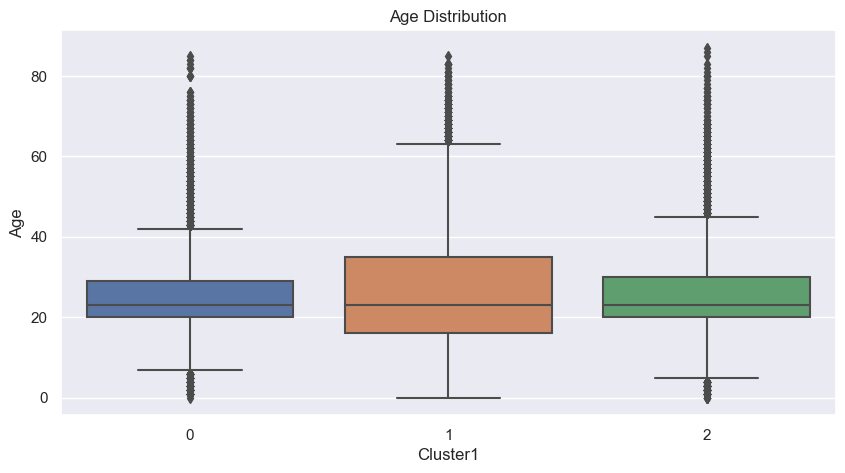

In [28]:
#plot the age distribution of the clusters
plt.figure(figsize=(10,5))
sns.boxplot(x=df["Cluster1"], y=df["Age"])
plt.title("Age Distribution")


Text(0.5, 1.0, 'Dropout Rate')

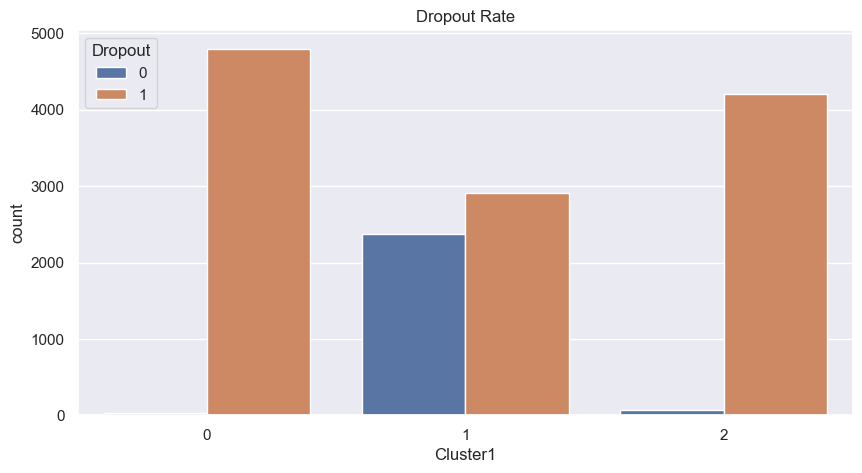

In [29]:
#plot the drop out rate of the clusters
plt.figure(figsize=(10,5))
sns.countplot(x=df["Cluster1"], hue=df["Dropout"])
plt.title("Dropout Rate")

In [30]:
df[df["Cluster1"]==0]["Dropout"].value_counts(normalize=True)

Dropout
1    0.994614
0    0.005386
Name: proportion, dtype: float64

In [31]:
df[df["Cluster1"]==1]["Dropout"].value_counts(normalize=True)

Dropout
1    0.55
0    0.45
Name: proportion, dtype: float64

In [32]:
df[df["Cluster1"]==2]["Dropout"].value_counts(normalize=True)

Dropout
1    0.983845
0    0.016155
Name: proportion, dtype: float64

In [33]:
df[df["Dropout"]==0]["Cluster1"].value_counts(normalize=True)

Cluster1
1    0.961554
2    0.027924
0    0.010522
Name: proportion, dtype: float64

# Cluster Using Age, Income and RFM_Score

## Cluster 2
Combines demographic information (Age, Income) with behavioral data (RFM Score) to create more comprehensive customer segments.


In [34]:
df2= df[["Age","Income","RFM_Score"]]

In [35]:
scaler= MinMaxScaler()
scaler.fit(df2)
df2_scaled = scaler.transform(df2)
df2_scaled = pd.DataFrame(df2_scaled, index=df2.index, columns=df2.columns)
df2_scaled.head()

,Age,Income,RFM_Score
ID,,,
10001,0.333333,0.241506,0.416667
10002,0.264368,0.181818,0.833333
10003,0.103448,0.000000,0.750000
10004,0.402299,0.396694,0.333333
10005,0.275862,0.203857,0.416667


c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The 

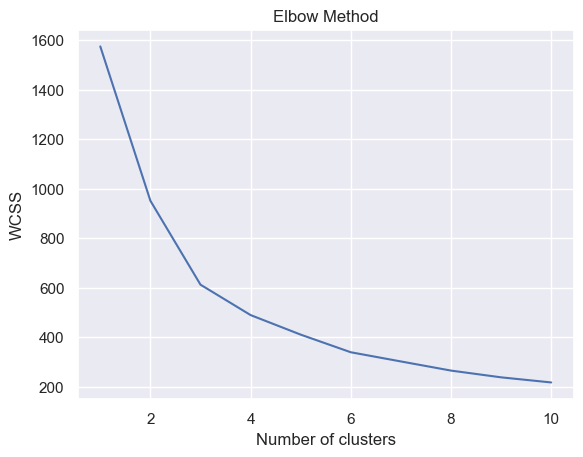

In [36]:
#perform elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, random_state=42)
    kmeans.fit(df2_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [37]:
#plot silhouette score for each cluster solution
range_clusters = range(2, 11)
silhouette = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df2_scaled)
    silhouette.append(silhouette_score(df2_scaled, kmclust.labels_))  # save the inertia of the given cluster solution
    

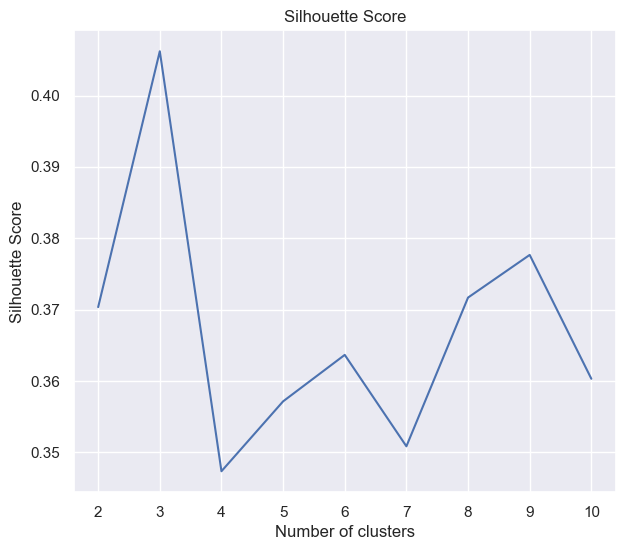

In [38]:
# The average silhouette plot
plt.figure(figsize=(7, 6))
plt.plot(range_clusters, silhouette)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The 

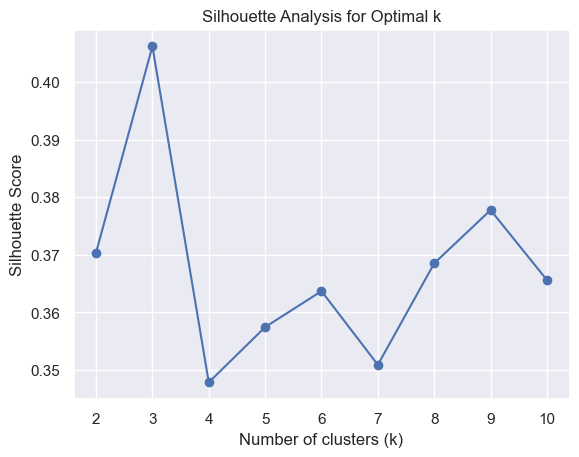

In [39]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df2_scaled)  # X is your data
    silhouette_avg = silhouette_score(df2_scaled, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [40]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df2_scaled)

array([14377,  9571, 14375, ...,     2,     1,     0], dtype=int64)

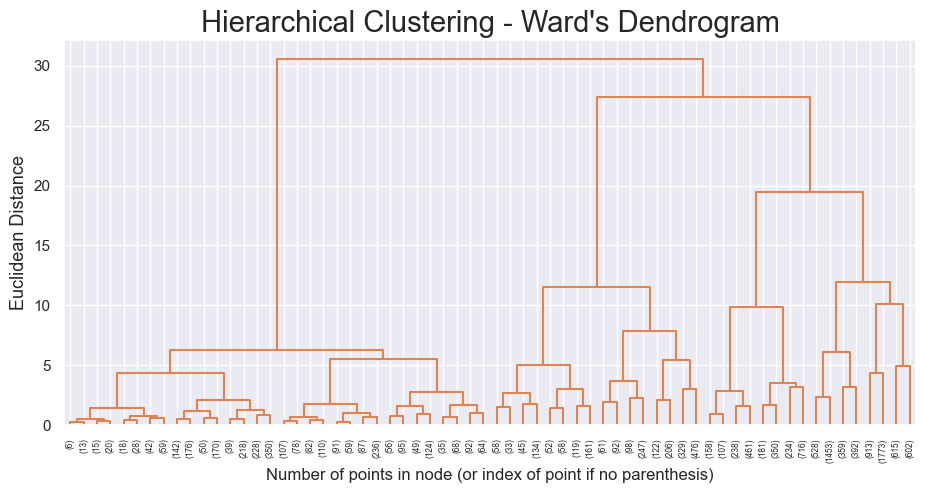

In [41]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

## Final Decision: K=3

In [42]:
#perform kmeans clustering with 3 clusters
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans.fit(df2_scaled)
cluster_labels = kmeans.labels_

c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [43]:
#show how many customers are in each cluster
df2_scaled["Cluster2"] = cluster_labels
df2["Cluster2"] = cluster_labels
df["Cluster2"] = cluster_labels
df["Cluster2"].value_counts()

C:\Users\diogo\AppData\Local\Temp\ipykernel_4476\347035223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Cluster2"] = cluster_labels


Cluster2
1    6163
0    5727
2    2488
Name: count, dtype: int64

In [44]:
#get the silhouette score for the clustering
silhouette_score(df2_scaled, cluster_labels)

0.7702446601931447

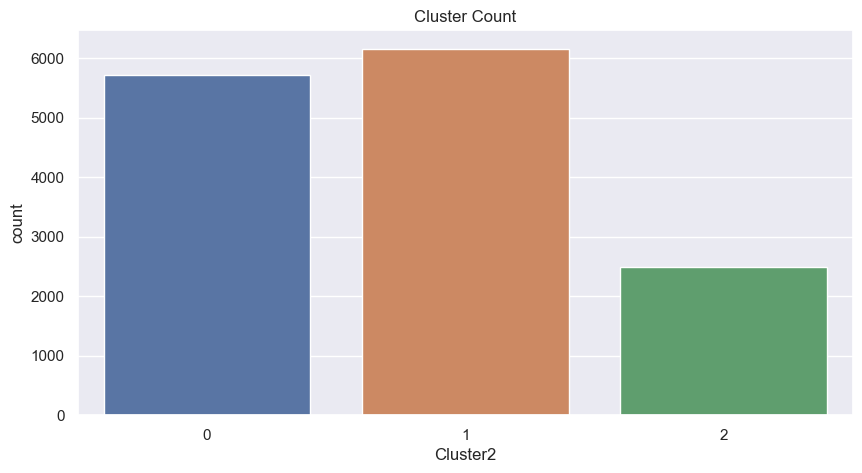

In [45]:
#plot the clusters in terms of count
plt.figure(figsize=(10,5))
sns.countplot(x=df["Cluster2"])
plt.title("Cluster Count")
plt.show()


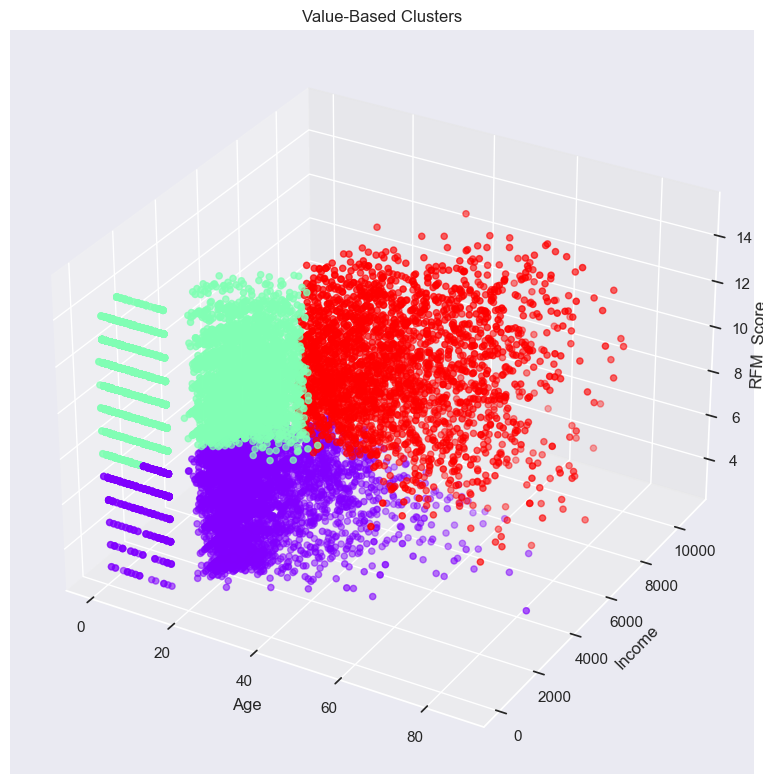

In [46]:
#plot 3d scatter plot of the clusters
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["Age"], df["Income"], df["RFM_Score"], c=df["Cluster2"], cmap='rainbow')

ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('RFM_Score')
ax.set_title('Value-Based Clusters')

ax.zaxis.labelpad=-0.8 
# Adjust layout to make sure z-axis label is visible
plt.tight_layout()
#add legend of colors

plt.show()


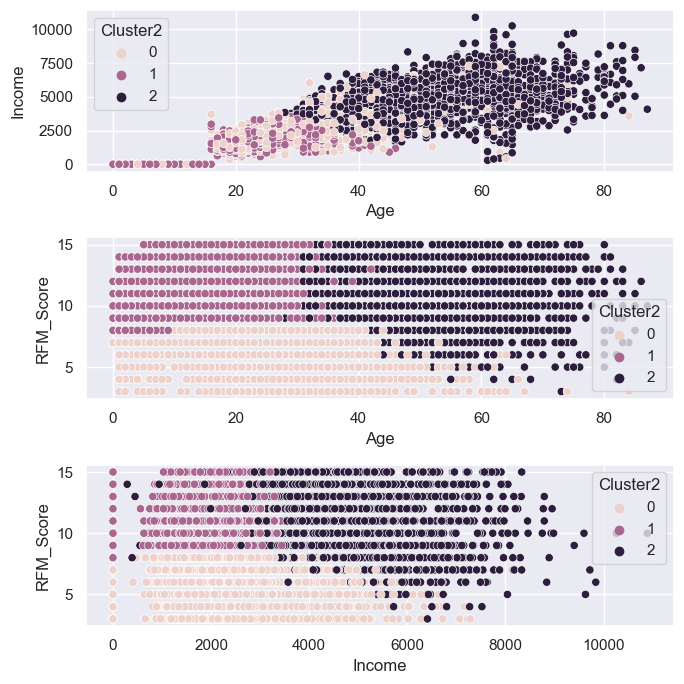

In [47]:
#plot the clusters in terms of Age, Income and RFM_Score
fig, axs = plt.subplots(3, 1, figsize=(7, 7))
sns.scatterplot(x="Age", y="Income", hue="Cluster2", data=df, ax=axs[0])
sns.scatterplot(x="Age", y="RFM_Score", hue="Cluster2", data=df, ax=axs[1])
sns.scatterplot(x="Income", y="RFM_Score", hue="Cluster2", data=df, ax=axs[2])
plt.tight_layout()
plt.show()

In [48]:
df.columns

Index(['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue',
       'NumberOfFrequencies', 'AttendedClasses', 'AllowedWeeklyVisitsBySLA',
       'AllowedNumberOfVisitsBySLA', 'RealNumberOfVisits', 'NumberOfRenewals',
       'NumberOfReferences', 'LastPeriodDuration', 'Recency',
       'EnrollmentDuration_semesters', 'Monetary', 'Frequency', 'Gender',
       'UseByTime', 'AthleticsActivities', 'WaterActivities',
       'FitnessActivities', 'DanceActivities', 'TeamActivities',
       'RacketActivities', 'CombatActivities', 'NatureActivities',
       'SpecialActivities', 'OtherActivities', 'HasReferences', 'Dropout',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Segment', 'RFM_Score',
       'RFM_Score_Labels', 'Cluster1', 'Cluster2'],
      dtype='object')

In [49]:
#plot the clusters in terms of features
features2 = ['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue',"Recency", "Frequency", "Monetary"]

df.groupby("Cluster2")[features2].mean()




,Age,Income,DaysWithoutFrequency,LifetimeValue,Recency,Frequency,Monetary
Cluster2,,,,,,,
0,23.952855,2002.835134,146.216693,165.891351,1114.846866,7.851824,84.418244
1,18.777057,1359.828600,38.144572,394.667519,531.211423,21.887958,164.235728
2,48.841238,4606.146610,54.012460,437.758428,534.795820,22.598562,161.689327


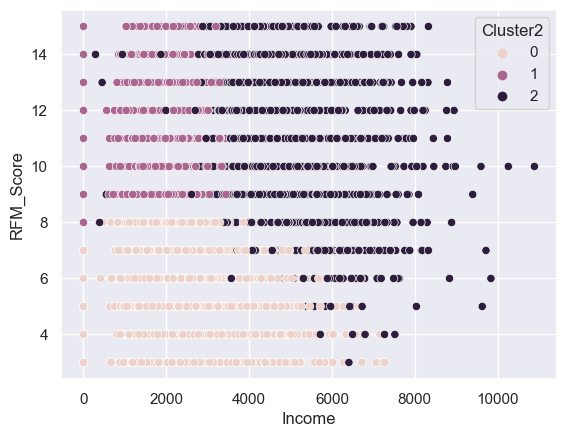

In [50]:
#plot the clusters in terms of age and income
sns.scatterplot(x="Income", y="RFM_Score", hue="Cluster2", data=df2)
plt.show()

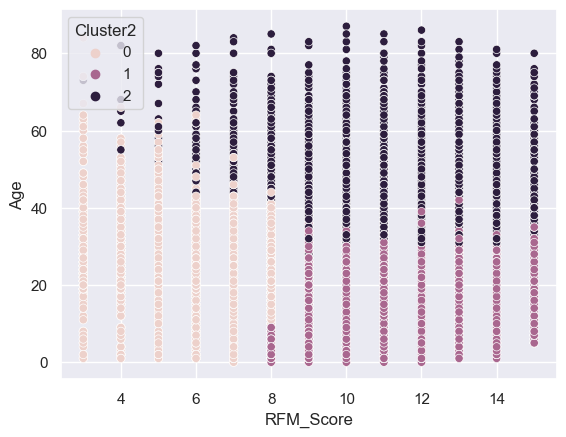

In [51]:
sns.scatterplot(x="RFM_Score", y="Age", hue="Cluster2", data=df2)
plt.show()

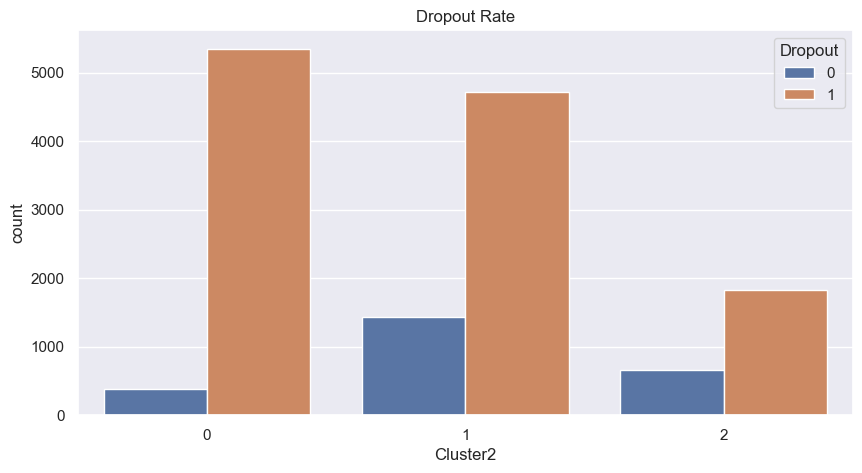

In [52]:
#plot clusters in term of dropout rate
plt.figure(figsize=(10,5))
sns.countplot(x=df["Cluster2"], hue=df["Dropout"])
plt.title("Dropout Rate")
plt.show()

In [53]:
df[df["Dropout"]==0]["Cluster2"].value_counts(normalize=True)

Cluster2
1    0.582760
2    0.265075
0    0.152165
Name: proportion, dtype: float64

# Cluster Using Age, Income, Frequency and Monetary

## Cluster 3
Clustering with Age, Income, Frequency, and Monetary creates a  segmentation that considers both the financial and demographic aspects of customer behavior


In [54]:
df3= df[["Age","Income","Frequency","Monetary"]]
df3.head()

,Age,Income,Frequency,Monetary
ID,,,,
10001,29,2630.0,9.871245,205.665236
10002,23,1980.0,35.294118,221.176471
10003,9,0.0,20.000000,155.400000
10004,35,4320.0,9.468822,86.189376
10005,24,2220.0,18.666667,93.333333


-Scaling the data

In [55]:
scaler= MinMaxScaler()
scaler.fit(df3)
df3_scaled = scaler.transform(df3)
df3_scaled = pd.DataFrame(df3_scaled, index=df3.index, columns=df3.columns)
df3_scaled.head()

,Age,Income,Frequency,Monetary
ID,,,,
10001,0.333333,0.241506,0.084818,0.182834
10002,0.264368,0.181818,0.305326,0.196677
10003,0.103448,0.000000,0.172671,0.137974
10004,0.402299,0.396694,0.081328,0.076206
10005,0.275862,0.203857,0.161106,0.082582


## Defining optimal K

c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The 

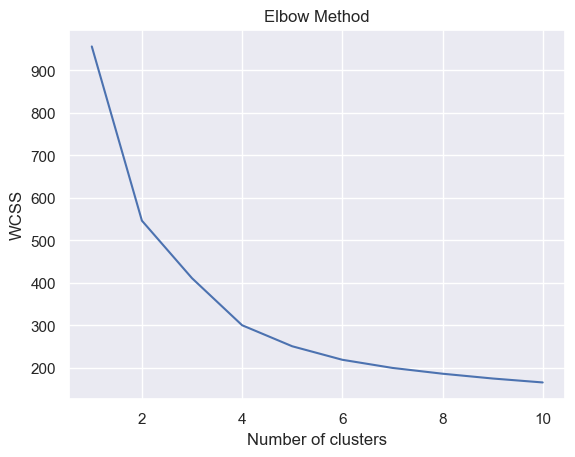

In [56]:
#perform elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, random_state=42)
    kmeans.fit(df3_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [57]:
#plot silhouette score for each cluster solution
range_clusters = range(2, 11)
silhouette = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df3_scaled)
    silhouette.append(silhouette_score(df3_scaled, kmclust.labels_))  # save the inertia of the given cluster solution
    

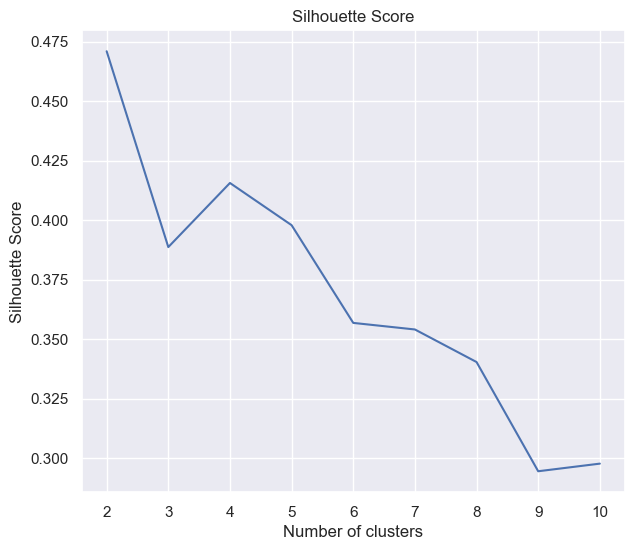

In [58]:
# The average silhouette plot
plt.figure(figsize=(7, 6))
plt.plot(range_clusters, silhouette)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The 

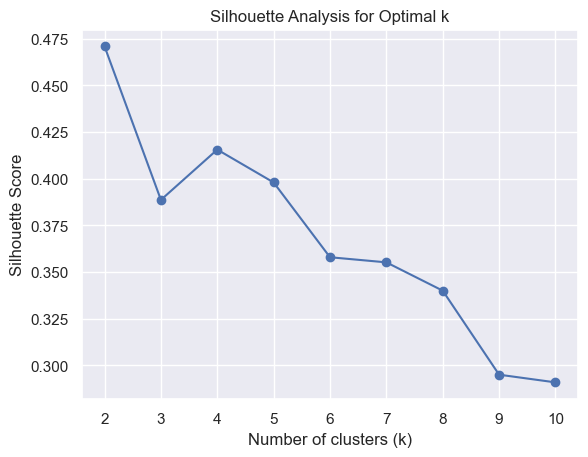

In [59]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df3_scaled)  # X is your data
    silhouette_avg = silhouette_score(df3_scaled, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [60]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df3_scaled)

array([ 9895, 13713, 11605, ...,     3,     1,     0], dtype=int64)

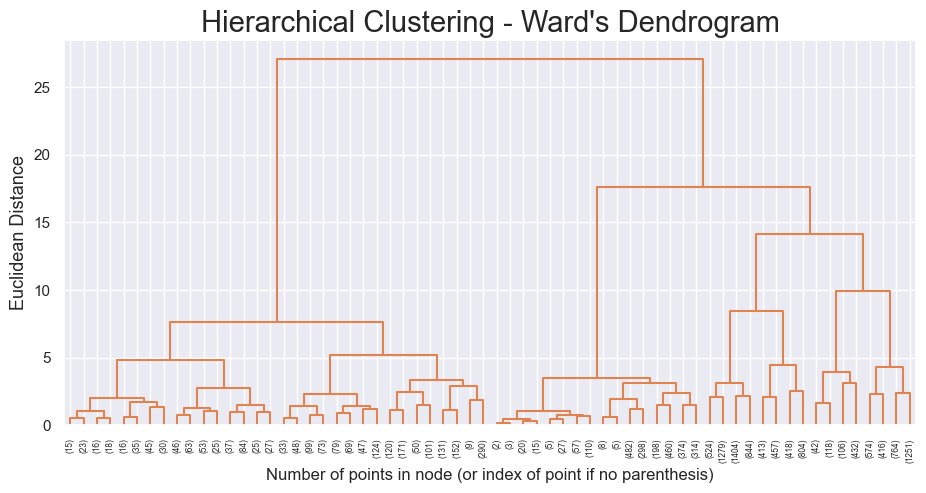

In [61]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [62]:
#perform kmeans clustering with 4 clusters
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans.fit(df3_scaled)
cluster_labels = kmeans.labels_


c:\Users\diogo\anaconda3\envs\environment_dm\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [63]:
#show how many customers are in each cluster
df3_scaled["Cluster3"] = cluster_labels
df3["Cluster3"] = cluster_labels
df["Cluster3"] = cluster_labels
df3["Cluster3"].value_counts()

C:\Users\diogo\AppData\Local\Temp\ipykernel_4476\1604702379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Cluster3"] = cluster_labels


Cluster3
0    11252
1     3126
Name: count, dtype: int64

In [64]:
#get the silhouette score for the clustering
silhouette_score(df3_scaled, cluster_labels)

0.7845981429748213

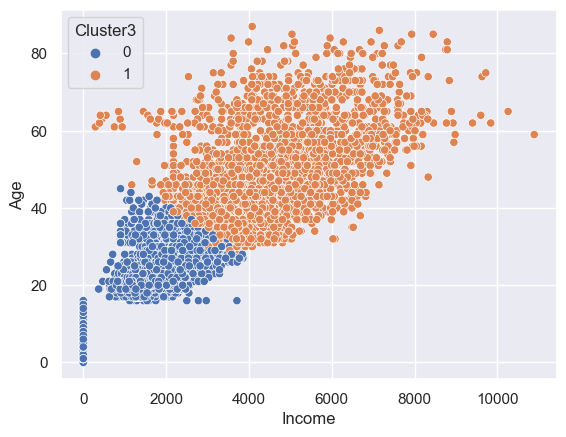

In [65]:
#plot the clusters in terms of age and income
sns.scatterplot(x="Income", y="Age", hue="Cluster3", data=df)
plt.show()

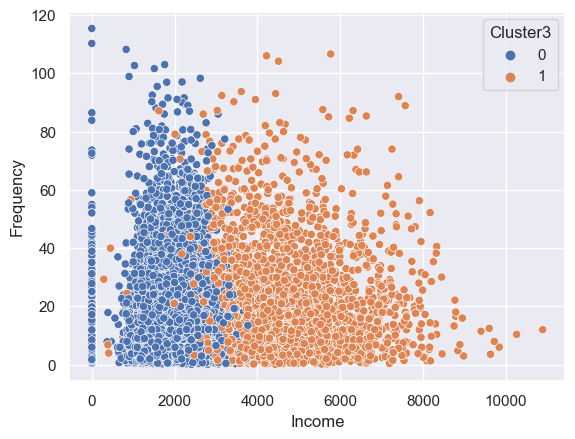

In [66]:
sns.scatterplot(x="Income", y="Frequency", hue="Cluster3", data=df3)
plt.show()

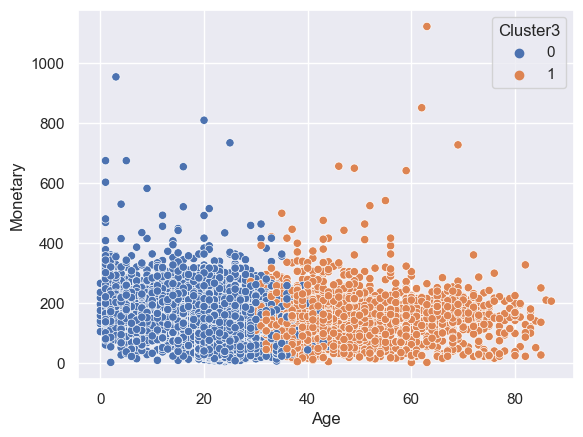

In [67]:
sns.scatterplot(x="Age", y="Monetary", hue="Cluster3", data=df3)
plt.show()

# DBSAN

In [68]:
df.columns

Index(['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue',
       'NumberOfFrequencies', 'AttendedClasses', 'AllowedWeeklyVisitsBySLA',
       'AllowedNumberOfVisitsBySLA', 'RealNumberOfVisits', 'NumberOfRenewals',
       'NumberOfReferences', 'LastPeriodDuration', 'Recency',
       'EnrollmentDuration_semesters', 'Monetary', 'Frequency', 'Gender',
       'UseByTime', 'AthleticsActivities', 'WaterActivities',
       'FitnessActivities', 'DanceActivities', 'TeamActivities',
       'RacketActivities', 'CombatActivities', 'NatureActivities',
       'SpecialActivities', 'OtherActivities', 'HasReferences', 'Dropout',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Segment', 'RFM_Score',
       'RFM_Score_Labels', 'Cluster1', 'Cluster2', 'Cluster3'],
      dtype='object')

In [69]:
df4= df[["Frequency","Recency", "EnrollmentDuration_semesters","UseByTime","NumberOfReferences","NumberOfRenewals","WaterActivities","FitnessActivities","TeamActivities","RacketActivities","CombatActivities","SpecialActivities","Dropout"]]

In [70]:
scaled = MinMaxScaler()
scaled.fit(df4)
df4_scaled = scaled.transform(df4)
df4_scaled = pd.DataFrame(df4_scaled, index=df4.index, columns=df4.columns)
df4_scaled.head()

,Frequency,Recency,EnrollmentDuration_semesters,UseByTime,NumberOfReferences,NumberOfRenewals,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,Dropout
ID,,,,,,,,,,,,,
10001,0.084818,0.805755,0.199446,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10002,0.305326,0.456835,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10003,0.172671,0.145427,0.076639,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0
10004,0.081328,0.370504,0.384118,0.0,0.0,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10005,0.161106,0.611511,0.122807,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [71]:
#perform dbscan clustering
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(df4_scaled)
df4_scaled["Cluster4"] = labels

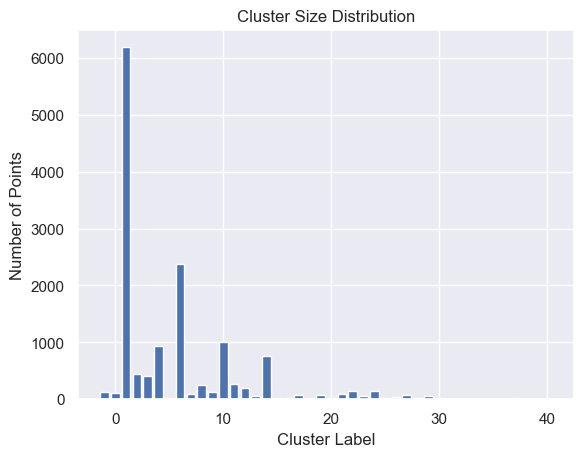

In [72]:
# Example: Visualize cluster size distribution
cluster_sizes = pd.Series(labels).value_counts()
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.show()

In [73]:
df.columns

Index(['Age', 'Income', 'DaysWithoutFrequency', 'LifetimeValue',
       'NumberOfFrequencies', 'AttendedClasses', 'AllowedWeeklyVisitsBySLA',
       'AllowedNumberOfVisitsBySLA', 'RealNumberOfVisits', 'NumberOfRenewals',
       'NumberOfReferences', 'LastPeriodDuration', 'Recency',
       'EnrollmentDuration_semesters', 'Monetary', 'Frequency', 'Gender',
       'UseByTime', 'AthleticsActivities', 'WaterActivities',
       'FitnessActivities', 'DanceActivities', 'TeamActivities',
       'RacketActivities', 'CombatActivities', 'NatureActivities',
       'SpecialActivities', 'OtherActivities', 'HasReferences', 'Dropout',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Segment', 'RFM_Score',
       'RFM_Score_Labels', 'Cluster1', 'Cluster2', 'Cluster3'],
      dtype='object')